# **Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)

# **Lab 00:** **E**xploratory **D**ata **A**nalysis (**EDA**)



In this lab session, we will work on **EDA** for different computer vision tasks such as image classification, semantic segmentation, object detection, among others.

  <p align="center">
    <img width=1000 src="https://drive.google.com/uc?export=view&id=100SrNjZYImVzl23skof3E_N7p_wF8qvg" alt="Computer Vision Tasks"/>
  </p>

**What is the purpose of an EDA?**

</br>
</br>
</br>

EDA is the **first thing** you should do when you receive a dataset. EDA can help with:
- the detection of obvious errors (acquisition errors, noisy or blurred samples, different brightness and contrast conditions),
- a better comprehension of data patterns (appearance, texture, context),
- the detection of outliers or unexpected events, and more!

## **Mount Google Drive to Google Colab**

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

Change **this path** to the **path of a folder** in your Google Drive to storage the files associated to this session (trained model, figures for visualization, etc.)

In [21]:
# # %cd drive/MyDrive/PATH/TO/FOLDER
# %cd drive/MyDrive/Colabs/DeepLearning_course

## **Datasets**

### **Load packages and data**

In [22]:
# Management of files
import os
from os.path import join,basename
from glob import glob
from natsort import natsorted

# Working with images
import tifffile
import cv2
import imagesize

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Working with arrays
import numpy as np

# Dataframes
import pandas as pd

**Variables**

In [23]:
# PROJECT_DIR = "." # os.getcwd()
# Get the current directory of the script
current_dir = os.path.dirname(__file__) if "__file__" in locals() else "."
 

### **Classification dataset**

For classification, we will use the [UC Merced](http://weegee.vision.ucmerced.edu/datasets/landuse.html) dataset.

This dataset has the following folder structure:


```
+--- UCMerced_LandUse
|   +--- Images
|   |   +--- agricultural
|   |   |   +--- agricultural00.tif
|   |   |   +--- ...
|   |   +--- airplane
|   |   +--- baseballdiamond
|   |   +--- beach
|   |   +--- ...
```

Some samples of the UC Merced dataset:
<center>
<img width=600 src="https://storage.googleapis.com/tfds-data/visualization/fig/uc_merced-2.0.0.png">
</center>

**What are the inputs and outputs of a classification model?**

Let's get information about the image files in each subfolder.

_If you want to run the following lines of code, you must download the UCMerced dataset from the given link. Then, change the variable `path_data_class` according to the folder where you uploaded the dataset._

In [24]:
path_data_class = join(current_dir,
                       "UCMerced_LandUse")

# List with all TIF images in the folder
list_class_img = glob(join(path_data_class,
                           "Images",
                           "**",
                           "*.tif"),
                      recursive=True)

list_class_img = natsorted(list_class_img, key=lambda y: y.lower())

df_class = pd.DataFrame(list_class_img, columns=["path_image"])
# Getting class name from filename path
# Example:
#   Input: '.\\UCMerced_LandUse\\Images\\agricultural\\agricultural04.tif'
#   Output: agricultural
# Use the below code to see the path
# for path in df_class["path_image"].head():
#     print(path.split("/"))



df_class["class_str"] = df_class["path_image"].apply(lambda x: x.split("\\")[-2])

# Getting available classes
classes = np.unique(df_class["class_str"].values)
# Indices for all classes
classes_int = np.arange(len(classes))
# Dictionary with classes (str) and their indices (int)
classes_dict = dict(zip(classes, classes_int))
# Applying the dictionary to the column "class"
df_class["class_int"] = df_class["class_str"].apply(lambda x: classes_dict[x])

# Shuffle the dataframe rows without keeping the old index
df_class = df_class.sample(frac=1).reset_index(drop=True)

print("Number of images: {}".format(len(list_class_img)))

Number of images: 2100


**Recommendation:** perform sanity checks to verify that each variable has the proper values.

Let's verify the image paths and their classes.

In [25]:
# Sanity check
for key,value in df_class.items():
  print("key:{}, value:{}".format(key,
                                  value[0]))

df_class

key:path_image, value:.\UCMerced_LandUse\Images\mobilehomepark\mobilehomepark93.tif
key:class_str, value:mobilehomepark
key:class_int, value:13


,path_image,class_str,class_int
0,.\UCMerced_LandUse\Images\mobilehomepark\mobil...,mobilehomepark,13
1,.\UCMerced_LandUse\Images\intersection\interse...,intersection,11
2,.\UCMerced_LandUse\Images\overpass\overpass45.tif,overpass,14
3,.\UCMerced_LandUse\Images\denseresidential\den...,denseresidential,6
4,.\UCMerced_LandUse\Images\buildings\buildings8...,buildings,4
...,...,...,...
2095,.\UCMerced_LandUse\Images\airplane\airplane94.tif,airplane,1
2096,.\UCMerced_LandUse\Images\agricultural\agricul...,agricultural,0
2097,.\UCMerced_LandUse\Images\intersection\interse...,intersection,11
2098,.\UCMerced_LandUse\Images\denseresidential\den...,denseresidential,6


Now, we can get the available classes in the dataset.

In [26]:
# Check available classes
classes_unique = df_class["class_str"].unique()
print("Number of classes: {}".format(len(classes_unique)))
np.sort(classes_unique)

Number of classes: 21


array(['agricultural', 'airplane', 'baseballdiamond', 'beach',
       'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway',
       'golfcourse', 'harbor', 'intersection', 'mediumresidential',
       'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway',
       'sparseresidential', 'storagetanks', 'tenniscourt'], dtype=object)

### **Segmentation dataset**


For semantic segmentation, we will use the [ISPRS Vaihingen](https://www.isprs.org/education/benchmarks/UrbanSemLab/2d-sem-label-vaihingen.aspx) dataset.

This dataset has the following folder structure:

```
+--- ISPRS_semantic_labeling_Vaihingen
|   +--- dsm
|   |   +--- dsm_09cm_matching_area1.tif
|   |   +--- dsm_09cm_matching_area10.tif
|   |   +--- ...
|   +--- gts
|   |   +--- top_mosaic_09cm_area1.tif
|   |   +--- top_mosaic_09cm_area10.tif
|   |   +--- ...
|   +--- top
|   |   +--- top_mosaic_09cm_area1.tif
|   |   +--- top_mosaic_09cm_area10.tif
|   |   +--- ...
```

Some samples of the dataset: where (a) true orthophoto (top), (b) digital surface model (dsm), and (c) ground truths (gts)

<center>
<img width=900 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/examples_top_dsm_gts.png?width=500&height=196.7930029154519" img>
</center>

**What are the inputs and outputs of a segmentation model?**

**What can you notice from each image (top, dsm, gts)?**

Let's get information about the image files in each subfolder.

_If you want to run the following lines of code, you must download the ISPRS Vaihingen dataset from the given link. Then, change the variable `path_data_seg` according to the folder where you uploaded the dataset._

In [38]:
path_data_seg = join(current_dir,
                     "ISPRS_semantic_labeling_Vaihingen")

path_seg_dsm = join(path_data_seg, "dsm")
path_seg_gts = join(path_data_seg, "gts")
path_seg_top = join(path_data_seg, "top")


# List with all TIF images in each folder
list_seg_top = glob(join(path_seg_top,"*.tif"))
list_seg_top = natsorted(list_seg_top, key=lambda y: y.lower())

list_seg_dsm = glob(join(path_seg_dsm,"*.tif"))
list_seg_dsm = natsorted(list_seg_dsm, key=lambda y: y.lower())

list_seg_gts = glob(join(path_seg_gts,"*.tif"))
list_seg_gts = natsorted(list_seg_gts, key=lambda y: y.lower())

print("Number of images:\ntop:{}\tdsm:{}\tgts:{}".format(len(list_seg_top),
                                                         len(list_seg_dsm),
                                                         len(list_seg_gts)))

Number of images:
top:33	dsm:33	gts:16


For sanity check, let's verify the order of the files.

**Why is it important?**

In [39]:
# Sanity check
for top,dsm,gts in zip(list_seg_top,
                       list_seg_dsm,
                       list_seg_gts):
  print(basename(top),
        "\t",
        basename(dsm),
        "\t",
        basename(gts))

top_mosaic_09cm_area1.tif 	 dsm_09cm_matching_area1.tif 	 top_mosaic_09cm_area1.tif
top_mosaic_09cm_area2.tif 	 dsm_09cm_matching_area2.tif 	 top_mosaic_09cm_area3.tif
top_mosaic_09cm_area3.tif 	 dsm_09cm_matching_area3.tif 	 top_mosaic_09cm_area5.tif
top_mosaic_09cm_area4.tif 	 dsm_09cm_matching_area4.tif 	 top_mosaic_09cm_area7.tif
top_mosaic_09cm_area5.tif 	 dsm_09cm_matching_area5.tif 	 top_mosaic_09cm_area11.tif
top_mosaic_09cm_area6.tif 	 dsm_09cm_matching_area6.tif 	 top_mosaic_09cm_area13.tif
top_mosaic_09cm_area7.tif 	 dsm_09cm_matching_area7.tif 	 top_mosaic_09cm_area15.tif
top_mosaic_09cm_area8.tif 	 dsm_09cm_matching_area8.tif 	 top_mosaic_09cm_area17.tif
top_mosaic_09cm_area10.tif 	 dsm_09cm_matching_area10.tif 	 top_mosaic_09cm_area21.tif
top_mosaic_09cm_area11.tif 	 dsm_09cm_matching_area11.tif 	 top_mosaic_09cm_area23.tif
top_mosaic_09cm_area12.tif 	 dsm_09cm_matching_area12.tif 	 top_mosaic_09cm_area26.tif
top_mosaic_09cm_area13.tif 	 dsm_09cm_matching_area13.tif 	 top

## **Visualization**

***A picture is worth a thousand words***

Fortunately, we are working with images. So, we can visualize the images and perform a visual inspection:
* to have a better idea about the problem to be solved
  - Classification: context of each class, existence of more than one class per image (multilabel).
  - Segmentation: presence of each class in the image, level of detailed needed.
  - Object detection: size of the object and its context.
* to identify the variability of each class
* to think about the next steps (e.g., preprocessing to reduce blurring, data augmentation transformations)

### **Classification**

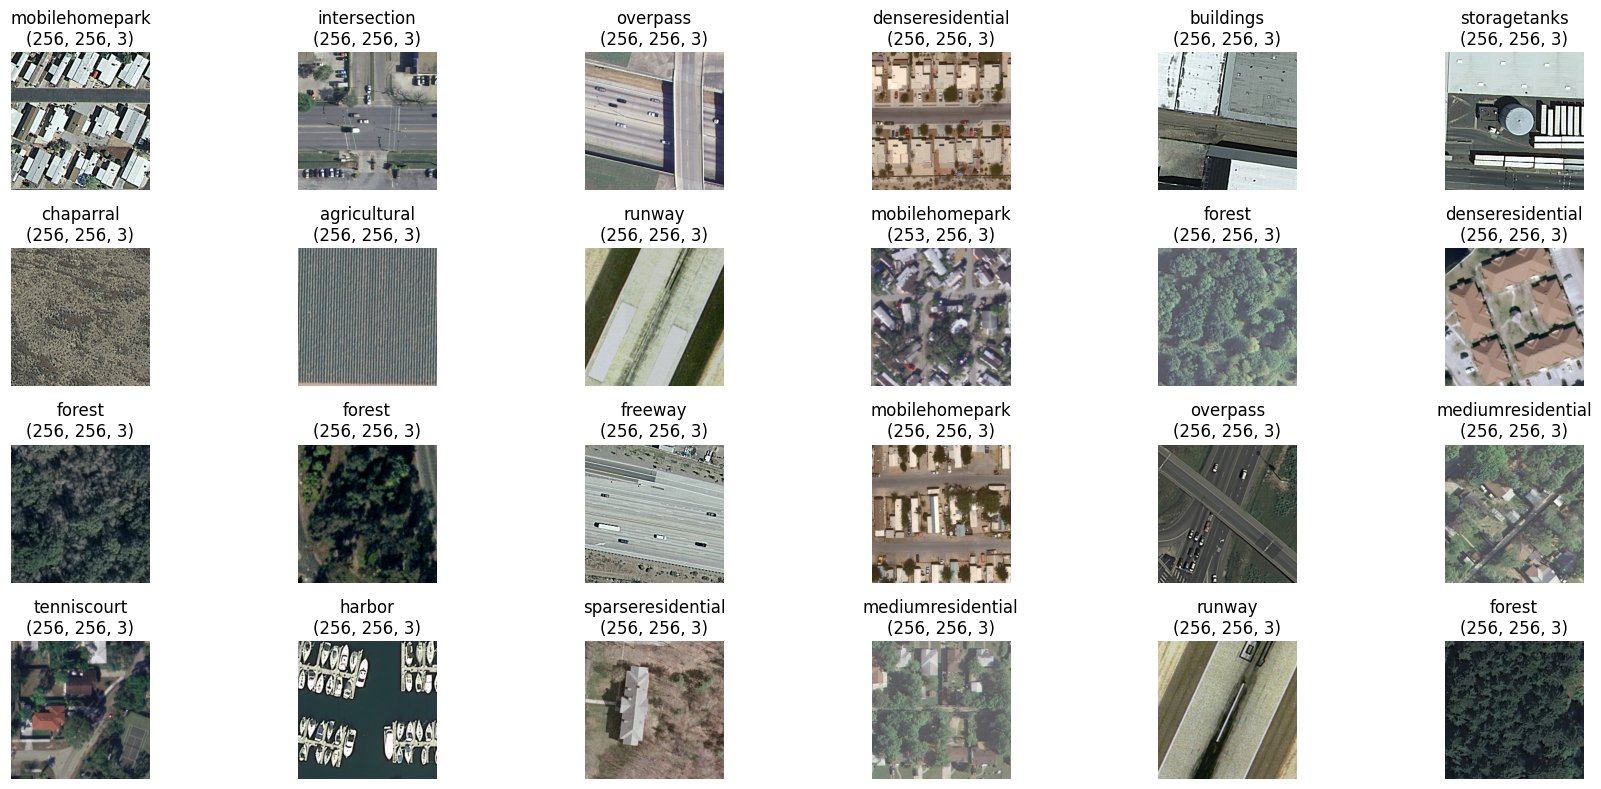

In [40]:
# Figure layout configuration
rows = 4
cols = 6
n_images = rows*cols

fig, axes = plt.subplots(rows,
                         cols,
                         figsize=(3*cols,2*rows))

for idx, row in df_class.head(n_images).iterrows():
  # reading the image
  image = tifffile.imread(row["path_image"])
  # getting the corresponding label
  label = row["class_str"]
  # positioning of each image in the figure
  ax = axes[idx//cols, idx%cols]
  ax.imshow(image)
  ax.set_title('{}\n{}'.format(label, image.shape))
  ax.axis("off")
plt.tight_layout()
plt.show()

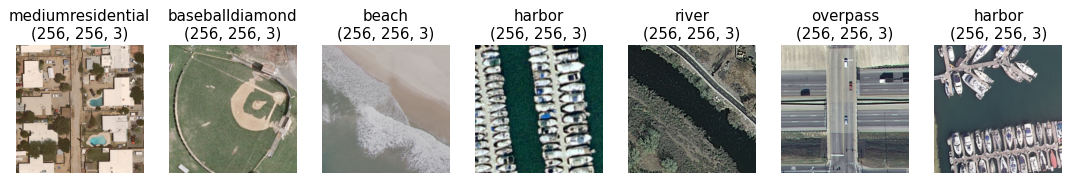

In [41]:
#@title **Samples Visualization** { run: "auto"}
#@markdown Select a sample
i = 111 #@param {type:"slider", min:0, max:299, step:1}
n = 7

plt.figure(figsize=(15,5), dpi=90)

for idx_df, row in df_class[i*n:i*n+n].iterrows():
  # reading the image
  image = tifffile.imread(row["path_image"])
  # getting the corresponding label
  label = row["class_str"]

  plt.subplot(1,n,idx_df-i*n+1)
  plt.imshow(image)
  plt.title('{}\n{}'.format(label, image.shape))
  plt.axis("off")

### **Segmentation**

Image: .\ISPRS_semantic_labeling_Vaihingen\top\top_mosaic_09cm_area16.tif


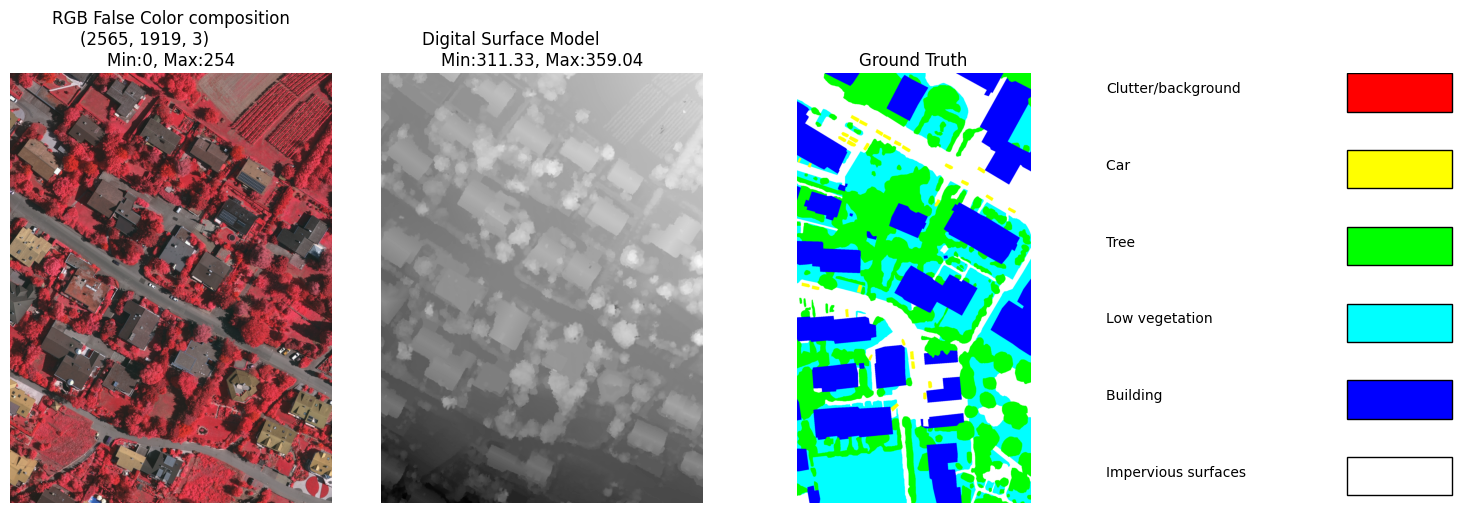

In [42]:
#@title **Samples Visualization** { run: "auto"}
#@markdown Select a sample
id_sample = 14 #@param {type:"slider", min:0, max:32, step:1}
img_top = tifffile.imread(list_seg_top[id_sample])
img_dsm = tifffile.imread(list_seg_dsm[id_sample])

print("Image: {}".format(list_seg_top[id_sample]))

plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.imshow(img_top)
plt.title("RGB False Color composition\n{}\
          \nMin:{}, Max:{}".format(img_top.shape,
                                     img_top.min(),
                                     img_top.max()))
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_dsm, cmap="gray")
plt.title("Digital Surface Model\
            \nMin:{:.2f}, Max:{:.2f}".format(img_dsm.min(),
                                             img_dsm.max()))
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(tifffile.imread(list_seg_gts[id_sample]))
plt.title("Ground Truth")
plt.axis("off")

g = plt.subplot(1,4,4)
g.axes.set_xlim(0,3.4)
g.axes.set_ylim(-0.01,0.55)

g.text(0, 0.025, "Impervious surfaces")
g.text(0, 0.125, "Building ")
g.text(0, 0.225, "Low vegetation")
g.text(0, 0.325, "Tree ")
g.text(0, 0.425, "Car ")
g.text(0, 0.525, "Clutter/background")

x_rec = 2.3
g.add_patch(patches.Rectangle((x_rec,0.0), 1, 0.05, facecolor="#FFFFFF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.1), 1, 0.05, facecolor="#0000FF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.2), 1, 0.05, facecolor="#00FFFF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.3), 1, 0.05, facecolor="#00FF00", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.4), 1, 0.05, facecolor="#FFFF00", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.5), 1, 0.05, facecolor="#FF0000", edgecolor="black"))
g.axis("off")

plt.tight_layout()
plt.show()

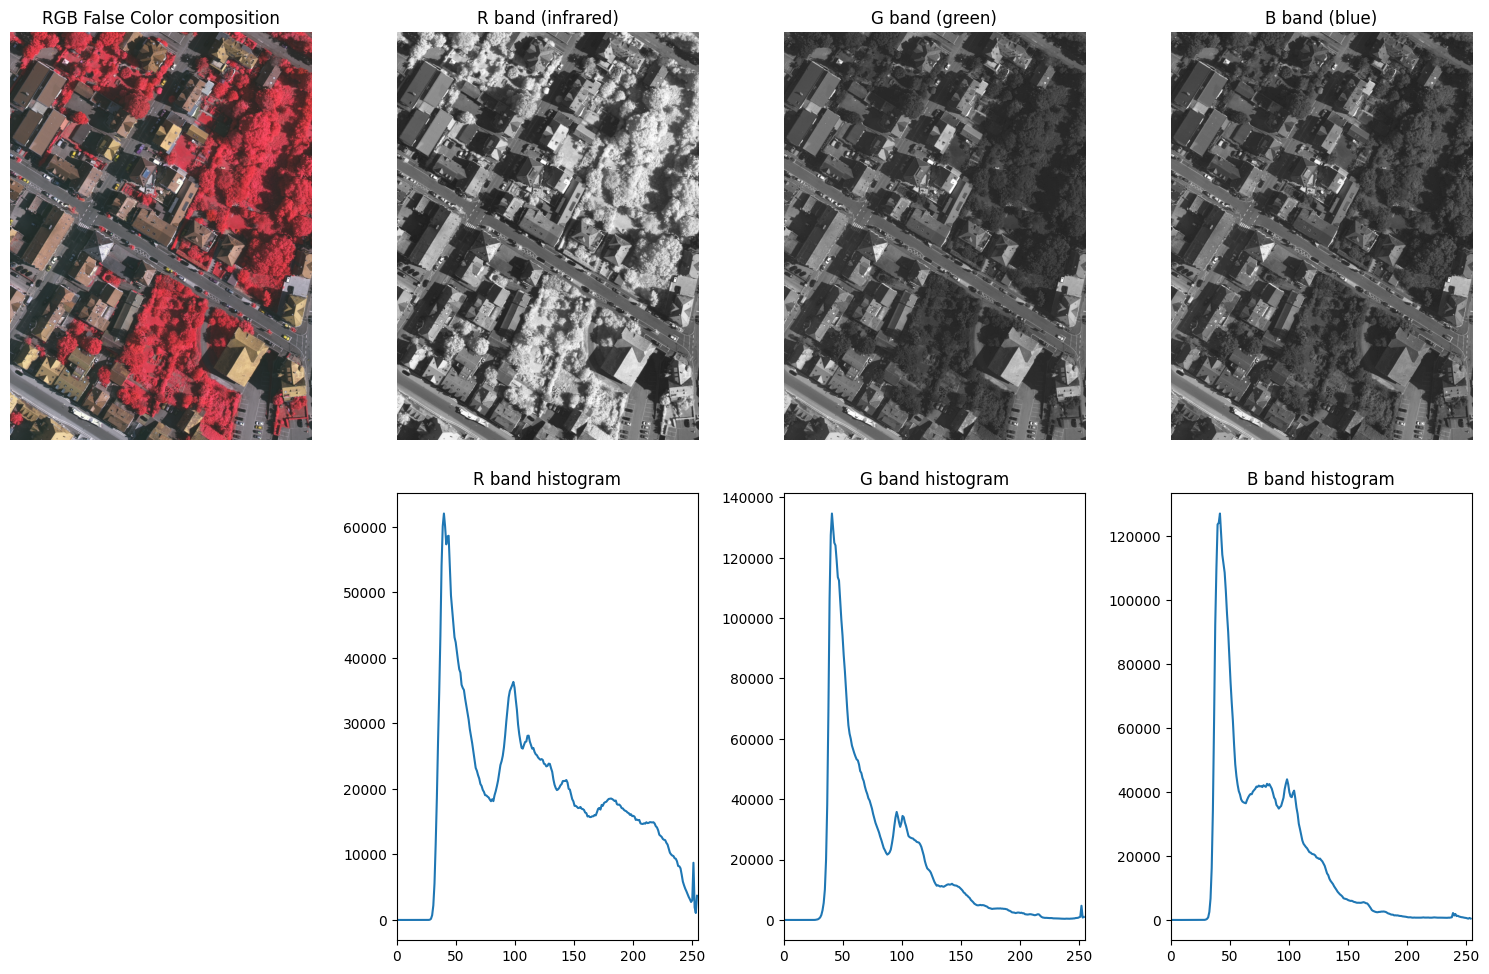

In [43]:
#@title **Bands Visualization** { run: "auto"}
#@markdown Select a sample
id_sample = 6 #@param {type:"slider", min:0, max:32, step:1}
img_top = tifffile.imread(list_seg_top[id_sample])

# Getting R, G and B bands
band_r = img_top[...,0]
band_g = img_top[...,1]
band_b = img_top[...,2]

# Computing histograms per band
hist_r, bin_r = np.histogram(band_r,
                             bins=256,
                             range=(0, 255)
                             )
hist_g, bin_g = np.histogram(band_g,
                             bins=256,
                             range=(0, 255)
                             )
hist_b, bin_b = np.histogram(band_b,
                             bins=256,
                             range=(0, 255)
                             )

plt.figure(figsize=(15,10))

plt.subplot(2,4,1)
plt.imshow(img_top)
plt.title("RGB False Color composition")
plt.axis("off")

plt.subplot(2,4,2)
plt.imshow(band_r, cmap="gray")
plt.title("R band (infrared)")
plt.axis("off")

plt.subplot(2,4,3)
plt.imshow(band_g, cmap="gray")
plt.title("G band (green)")
plt.axis("off")

plt.subplot(2,4,4)
plt.imshow(band_b, cmap="gray")
plt.title("B band (blue)")
plt.axis("off")

plt.subplot(2,4,6)
plt.xlim([0.0, 255.0])
plt.plot(bin_r[0:-1], hist_r)
plt.title("R band histogram")

plt.subplot(2,4,7)
plt.xlim([0.0, 255.0])
plt.plot(bin_g[0:-1], hist_g)
plt.title("G band histogram")

plt.subplot(2,4,8)
plt.xlim([0.0, 255.0])
plt.plot(bin_b[0:-1], hist_b)
plt.title("B band histogram")

plt.tight_layout()
plt.show()

## **Image information**

It is important to get all possible information of each image such as
* image sizes
* image data types
* etc.

So, we can think about how to train our models later.

### **Classification**

In [44]:
# Getting image sizes
# (this cell can take several minutes, ~18 min.)
img_sizes = []
for idx,row in df_class.iterrows():
  img_sizes.append(imagesize.get(row["path_image"]))

In [45]:
# filter only unique values
set(img_sizes)

{(242, 256),
 (247, 247),
 (247, 256),
 (249, 256),
 (250, 256),
 (252, 256),
 (253, 256),
 (254, 256),
 (255, 256),
 (256, 247),
 (256, 249),
 (256, 251),
 (256, 253),
 (256, 254),
 (256, 255),
 (256, 256),
 (257, 257)}

### **Segmentation**

In [46]:
# check images information
for top,dsm,gts in zip(list_seg_top,
                       list_seg_dsm,
                       list_seg_gts):
  top_img = tifffile.imread(top)
  dsm_img = tifffile.imread(dsm)
  gts_img = tifffile.imread(gts)

  print("file:{}\
        \ttop:{},{},{}\
        \tdsm:{},{},{}\
        \tgts:{},{},{}".format(basename(top),
                             top_img.shape,
                             (top_img.min(),top_img.max()),
                             top_img.dtype,
                             dsm_img.shape,
                             (dsm_img.min(),dsm_img.max()),
                             dsm_img.dtype,
                             gts_img.shape,
                             (gts_img.min(),gts_img.max()),
                             gts_img.dtype))

file:top_mosaic_09cm_area1.tif        	top:(2569, 1919, 3),(0, 255),uint8        	dsm:(2569, 1919),(258.03723, 296.33875),float32        	gts:(2569, 1919, 3),(0, 255),uint8
file:top_mosaic_09cm_area2.tif        	top:(2767, 2428, 3),(0, 255),uint8        	dsm:(2767, 2428),(242.35103, 291.86908),float32        	gts:(3007, 2006, 3),(0, 255),uint8
file:top_mosaic_09cm_area3.tif        	top:(3007, 2006, 3),(0, 255),uint8        	dsm:(3007, 2006),(251.01532, 287.465),float32        	gts:(2557, 1887, 3),(0, 255),uint8
file:top_mosaic_09cm_area4.tif        	top:(2557, 1887, 3),(0, 255),uint8        	dsm:(2557, 1887),(248.70993, 290.16205),float32        	gts:(2557, 1887, 3),(0, 255),uint8
file:top_mosaic_09cm_area5.tif        	top:(2557, 1887, 3),(0, 255),uint8        	dsm:(2557, 1887),(245.8814, 282.29233),float32        	gts:(2566, 1893, 3),(0, 255),uint8
file:top_mosaic_09cm_area6.tif        	top:(2557, 1887, 3),(0, 255),uint8        	dsm:(2557, 1887),(261.3076, 328.47195),float32        	g

## **Classes distribution**

Another factor with a critical impact on a model's performance is the classes distribution.

It is important to identify, if exists, the less represented classes (i.e., classes with less samples) to take actions to alleviate this problem. This can produce a bias in the model related to the classes with more samples.

There are many different options to alleviate the class imbalance in a dataset such as
* oversampling and undersampling,
* data augmentation focused on specific classes,
* give more importance to minor classes (e.g., using weights per sample in the loss function, focal loss)

### **Classification**

Let's get the number of samples for each class. In classification, this represents the number of images of each class.

Samples per class: [100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100]


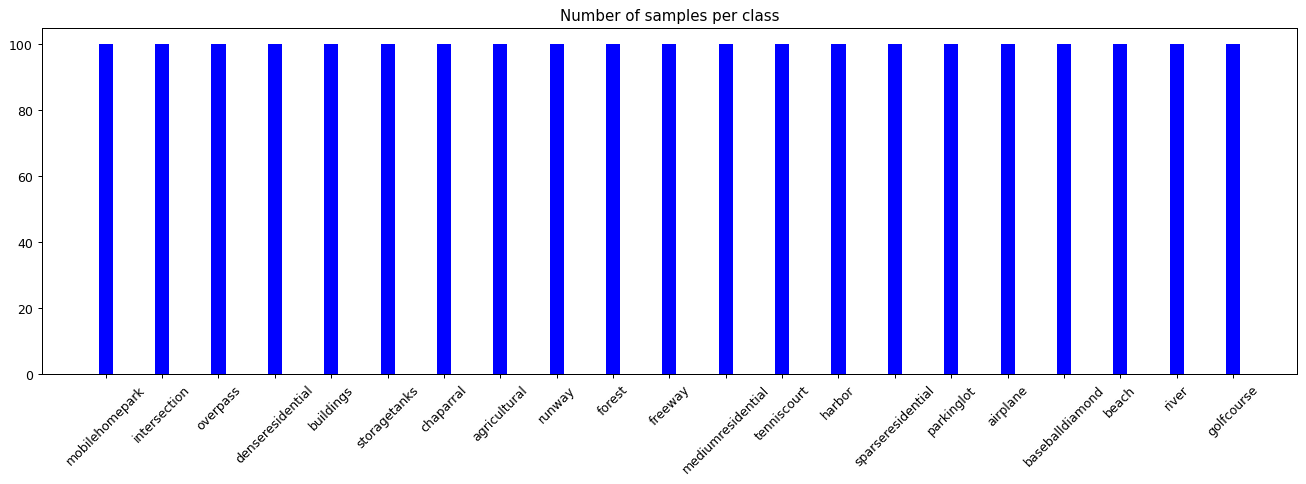

In [47]:
# Number of samples per class
_, counts_class = np.unique(df_class["class_int"],
                            return_counts=True)
# Number of classes
names_classes = df_class["class_str"].unique()
n_classes = len(names_classes)

# Figure configuration
bar_width = 0.25
br = np.arange(n_classes)

print("Samples per class: {}".format(counts_class))
# Bar plot
plt.figure(figsize=(18,5), dpi=90)

plt.bar(br, counts_class, width=bar_width, color="blue")
plt.xticks([r for r in range(n_classes)], names_classes, rotation=45)
plt.title("Number of samples per class")

plt.show()

**Important:** Check the class distribution of the **whole dataset** as well as in the **train** and **validation** sets for a proper training and evaluation of a model.

To balance these sets, you can use **stratified sampling** for instance:

```python
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  stratify=y_train)
```




### **Segmentation**

In segmentation, the number of samples per class is given by the number of pixels of each class.

Notice that the **number of images** might not be a real indicator of the **number of training samples** for this case, especially for the cases where the image is too big.

In those cases, **_patches_** are extracted from each image with a given **_stride_**. Then, the number of **_patches_** is used as the **"real number of images"** for training.

In [48]:
color2index = {(255,255,255) : 0,
               (0  ,0  ,255) : 1,
               (0  ,255,255) : 2,
               (0  ,255,0  ) : 3,
               (255,255,0  ) : 4,
               (255,0  ,0  ) : 5
               }
n_classes = len(color2index)

classes_str = ["Impervious surfaces",
               "Building",
               "Low vegetation",
               "Tree",
               "Car ",
               "Clutter/background"]

In [49]:
# Read all reference images
counts_all = np.zeros((len(list_seg_gts), n_classes),
                      dtype=np.int64)

for id_file, gts in enumerate(list_seg_gts):
  gts_img = tifffile.imread(gts)
  gts_img_idx = np.zeros((gts_img.shape[0],
                          gts_img.shape[1]),
                         dtype=np.uint8)
  for key in color2index:
    class_id = color2index[key]
    key = np.array(key)
    # Assign an index to each color based on the colormap
    # (255,255,255) : 0
    # (0  ,0  ,255) : 1,...
    gts_img_idx[(gts_img[:,:,0] == key[0]) &
                (gts_img[:,:,1] == key[1]) &
                (gts_img[:,:,2] == key[2])] = class_id

  unique_class, counts = np.unique(gts_img_idx, return_counts=True)
  print("File:{} | Classes:{} | Pixels:{}".format(basename(gts),
                                                  unique_class,
                                                  counts))
  for id_class, value in zip(unique_class, counts):
    counts_all[id_file, id_class] += value

counts_pixels = np.sum(counts_all, axis=0)
counts_pixels_perc = np.round(100*counts_pixels/np.sum(counts_pixels), 2)
print("\nTotal pixels:{} | [%]:{}".format(counts_pixels,
                                          counts_pixels_perc))

print("Classes: {}".format(classes_str))

File:top_mosaic_09cm_area1.tif | Classes:[0 1 2 3 4 5] | Pixels:[1753163 1852765  621535  626123   76323       2]
File:top_mosaic_09cm_area3.tif | Classes:[0 1 2 3 4] | Pixels:[2059368 1632260 1157157 1127394   55863]
File:top_mosaic_09cm_area5.tif | Classes:[0 1 2 3 4] | Pixels:[1684911 2426970  318578  327258   67342]
File:top_mosaic_09cm_area7.tif | Classes:[0 1 2 3 4] | Pixels:[1492394 1305092  637230 1282703  107640]
File:top_mosaic_09cm_area11.tif | Classes:[0 1 2 3 4] | Pixels:[1608732  904397  808152 1469029   67128]
File:top_mosaic_09cm_area13.tif | Classes:[0 1 2 3 4] | Pixels:[1185224 1302768 2549104 2144306   27042]
File:top_mosaic_09cm_area15.tif | Classes:[0 1 2 3 4 5] | Pixels:[ 855112 1075170 1309897 1643189   31684    7183]
File:top_mosaic_09cm_area17.tif | Classes:[0 1 2 3 4] | Pixels:[ 385227  500562 1328765  769763    8099]
File:top_mosaic_09cm_area21.tif | Classes:[0 1 2 3 4] | Pixels:[1382431  989524  630889 1805045   37149]
File:top_mosaic_09cm_area23.tif | Class

We can see that there are classes like ```Car``` with less than $2\%$ of the total number of samples.


**Important:** Check that the **train and validation** sets have samples of all classes.

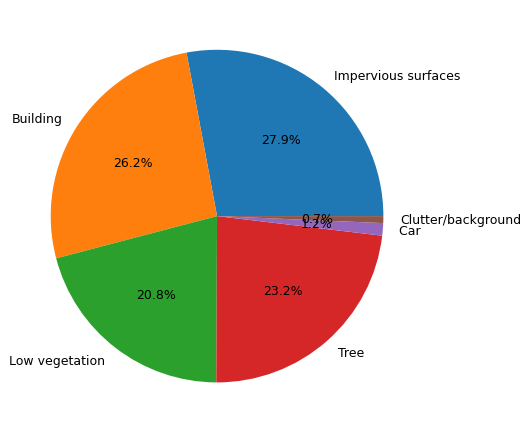

In [50]:
plt.figure(figsize=(6,6), dpi=90)
plt.pie(counts_pixels_perc,
        labels=classes_str,
        autopct='%1.1f%%')
plt.show()

## **Object detection**

**What are the inputs and outputs of an object detection model?**

Based on [Neptune post](https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection)

In object detection, the following image characteristics should be considered:

### **Images aspect ratio**

Taking a look at the **image widths, heights and aspect ratios** is important to decide in advance which method to use or if a preprocessing is necessary before training.

Let's see the image aspect ratios in the [COCO](https://cocodataset.org/#home) dataset (330K images (>200K labeled), 1.5 million object instances, 80 object categories):

  <p align="center">
    <img width=600 src="https://lh4.googleusercontent.com/OqktTL5_qLJbF4-TMis9dmrI1kJeUYM112scAmljOp9kLpCvrNnH-fPb0pDEK8FwBH5flN7MKZ-qMy5xCuLB_7AlGeIyEGZSFxHdHNKPARBrbU2gKvUk0B696hytRbJbdUHO6wo7" alt="Histogram aspect ratios COCO"/>
  </p>

Examples of cases with extreme aspect ratios. In these cases, the images can be resized or padded.

<p align="center">
    <img width=400 src="https://lh4.googleusercontent.com/rLTc7WxUDZKNxW_69kta67si8B0qpfhKEkjsI41SHbLOBygzGwZfMAHH-XSW2NY7TtUdIh58VEwRvEz2OWOFBjHOj9PwVWxfW9VY5XczDOLXdz_Pm9veRUGgxgXWAtZYK2M_ijhX" alt="Example extreme aspect ratio"/>
  </p>
  
  <p align="center">
    <img width=400 src="https://lh3.googleusercontent.com/pRs0EbOT7ZpxN-HLv_AnMOyNgQM0Rn92TBqwM1FQP0A2faSlriciiN7Bwdi0m8s5CUkIOb4cp9fGpRMeUkfwiW2nASLyJ-bPqDdo5IUI08Ea4hkSxza1RMpmuqCsCLVXsZIIEOpr" alt="Example extreme aspect ratio"/>
  </p>
  


  

### **Objects aspect ratio and area**

From the perspective of the **labels**, it is important to know the **size and aspect ratios of each object**.

This is important to select the right **parameters** of each method, especially those based on anchors generation (e.g., YOLO, RetinaNet).

Let's see the **aspect ratios** of objects in the COCO dataset:

  <p align="center">
    <img width=600 src="https://lh3.googleusercontent.com/AOK2YxzNjjJ7_bfEjA-X2w9YgTGbc5x9LJ5g73SeNr9VNCECRResmMWNNkMV7IgDpdPJPhSvCATgV9XFoXz_28mydnWuwwkUBAPSzH8-5R3DmVoFCoStI5BD6vjqZeQjYgZEvr_C" alt="object aspect ratios"/>
  </p>


### **Partially labeled data**

**Missing annotations** (i.e., objects not labeled) are potentially a huge issue. Not annotated objects will be considered as **background**, which might confuse the model learning.


Examples of images partially labeled:

[Source](https://arxiv.org/pdf/1812.02611.pdf)
  <p align="center">
    <img width=600 src="https://lh4.googleusercontent.com/sVVrm09hWRk40YcUGBeQNTWJqWL3pqsQjPmonzYKMpuTrABFj4URjLERRcnQEleDUzkuUh-26uZGrwoLbXKPugS3Be2Ypbz9AFuHa9PM9uektaxXVz_j3xc0SNVtmdkisq8BwnbJ" alt="partially labeled data"/>
  </p>


### **More information**

- acquisition angle (top of view or oblique images)
- annotation type (horizontal or oriented bounding boxes)
- annotation format (PASCAL VOC, COCO, or customised)
- class distribution (number of instances per class)

# **Git and GitHub**

## **Branches**

Branches are to add experimental features (temporal branches) or create different versions (regular branches) of your code.

  The `master` or a regular branch are modified by merging it with another branch only if this branch have been **tested** and it is **working properly**.

  There are many conventions for **naming branches**, one is the following:

  ```
  branch_type/id-brief_description
  ```    
  - `branch_type`: wip, bug, feature, v1.1,...
  - `id`: unique ID, might be related to an issue.
  - `brief_description`: short description of this branch, e.g. adding-reading-module, update-model-architecture.

  ```
  bug/0001-data-generator-memory-leak
  feature/0002-add-new-models
  ```   